In [46]:
# Install the torch package
%pip install torch

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import random


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [47]:
# AND NOW WE START WORKING WITH REAL DATA
class GoyalWelchData:
  def __init__(self):
    self.read_data()

  def read_data(self):
    import os
    import pandas as pd

    goyal_welch_data = pd.read_csv(os.path.join('../macro_data','GoyalWelchPredictorData2022Monthly.csv'), index_col=0)
    goyal_welch_data.index = pd.to_datetime(goyal_welch_data.index, format='%Y%m')
    
    monthly_returns = pd.read_csv(os.path.join('../macro_data','gld_monthly_returns.csv'))
    monthly_returns.index = pd.to_datetime(monthly_returns.Date, format='%Y-%m-%d')

    for column in goyal_welch_data.columns:
        goyal_welch_data[column] = [float(str(x).replace(',', '')) for x in goyal_welch_data[column]]
    
    self.monthly_returns = monthly_returns
    self.goyal_welch_data = goyal_welch_data
    self.get_cleaned_data()
    self.select_signals()

  def get_cleaned_data(self):
    start_date = np.max([self.goyal_welch_data.index.min(), self.monthly_returns.index.min()])
    end_date = np.min([self.goyal_welch_data.index.max(), self.monthly_returns.index.max()])
    self.goyal_welch_data = self.goyal_welch_data.loc[start_date:end_date]
    self.goyal_welch_data['excess_returns'] = self.monthly_returns['GLD'] - self.goyal_welch_data.Rfree
    self.cleaned_data = self.goyal_welch_data.loc[start_date:end_date].drop(columns=['csp']).fillna(0)

  def normalize(self,
                data: np.ndarray,
                ready_normalization: dict = None,
                use_std: bool = False):
    """

    """

    if ready_normalization is None:
        data_std = data.std(0)
        if use_std:
          data = data / data_std
        else:
          data_max = np.max(data, axis=0)
          data_min = np.min(data, axis=0)
    else:
        data_std = ready_normalization['std']
        if use_std:
          data = data / data_std
        else:
          data_max = ready_normalization['max']
          data_min = ready_normalization['min']

    data = data - data_min
    data = data/(data_max - data_min)
    data = data - 0.5
    normalization = {'std': data_std,
                      'max': data_max,
                      'min': data_min}
    return data, normalization

  def select_signals(self):
    signal_columns = ['Index', 'D12', 'E12', 'b/m', 'tbl', 'AAA', 'BAA', 'lty', 'ntis',
        'Rfree', 'infl', 'ltr', 'corpr', 'svar']
    cleaned_data = self.cleaned_data
    data_for_signals = cleaned_data[signal_columns].shift(1).fillna(0)
    labels = cleaned_data.excess_returns.values.reshape(-1, 1)
    signals = data_for_signals.values
    self.signals = signals

  def get_train_and_test_data(self, normalize_raw_data=True, cheat_and_use_future_data=False):
    signals = self.signals
    labels = self.cleaned_data.excess_returns.values.reshape(-1, 1)
    split = int(signals.shape[0] / 2)
    train_labels = labels[:split]
    test_labels = labels[split:]
    test_dates = self.cleaned_data.excess_returns.index[split:]

    if normalize_raw_data:
        signals[:split, :], normalization = self.normalize(signals[:split])
        if cheat_and_use_future_data:
          signals[split:, :] = self.normalize(signals[split:, :])[0]
        else:
          signals[split:, :] = self.normalize(signals[split:, :],
                                        ready_normalization=normalization)[0]
    train_data = signals[:split, :]
    test_data = signals[split:, :]
    return train_data, test_data, train_labels, test_labels, test_dates

  def sharpe_ratio(x):
    return np.round(np.sqrt(12) * x.mean(0) / x.std(0), 2)


In [48]:
goyal_welch_data = GoyalWelchData()
X_train, X_test, y_train, y_test, test_dates = goyal_welch_data.get_train_and_test_data()

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets and DataLoaders for training and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


/tmp/ipykernel_3389/163967974.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.goyal_welch_data['excess_returns'] = self.monthly_returns['GLD'] - self.goyal_welch_data.Rfree


In [49]:
class FlexibleMLP(nn.Module):
    def __init__(self, layers):
        super(FlexibleMLP, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        for i in range(len(layers) - 1):
            layer = nn.Linear(layers[i], layers[i+1])

            # LeCun initialization
            nn.init.normal_(layer.weight, mean=0.0, std=np.sqrt(1 / layers[i]))
            nn.init.normal_(layer.bias, mean=0.0, std=0 * np.sqrt(1 / layers[i]))

            self.layers.append(layer)
            # Add ReLU activation after each layer except the last
            if i < len(layers) - 2:
                self.activations.append(nn.ReLU())
            else:
                # Placeholder for the last layer's activation
                self.activations.append(nn.Identity())

    def forward(self, x, return_last_hidden=False):
        last_hidden = None

        for layer, activation in zip(self.layers[:-1], self.activations[:-1]):
            x = activation(layer(x))
            last_hidden = x  # Update last_hidden at each hidden layer

        # Apply the last layer without ReLU (or Identity for the placeholder)
        x = self.layers[-1](x)

        if return_last_hidden:
            return x, last_hidden
        return x

    def set_seed(seed_value=42):
      """Set seed for reproducibility."""
      np.random.seed(seed_value)  # Set NumPy seed
      torch.manual_seed(seed_value)  # Set PyTorch seed
      random.seed(seed_value)  # Set Python random seed

      # If you are using CUDA:
      if torch.cuda.is_available():
          torch.cuda.manual_seed(seed_value)
          torch.cuda.manual_seed_all(seed_value)  # For multi-GPU
          torch.backends.cudnn.deterministic = True
          torch.backends.cudnn.benchmark = False

In [50]:
def train_model(num_epochs: int,
                train_loader: DataLoader,
                criterion,
                optimizer,
                model):
  # Training loop
  for epoch in range(num_epochs):
      for inputs, targets in train_loader:
          # Forward pass
          outputs = model(inputs)
          loss = criterion(outputs, targets)

          # Backward and optimize
          optimizer.zero_grad() # kill old gradients
          loss.backward() # compute new gradients
          optimizer.step() # perform the step of gradient descent

      if (epoch+1) % 20 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


# A model is just a neural net. That is, a spefic parametric family of functions, $f(x;\theta).$ The big question is how to find the right parameter $\theta.$ The neural net first random initialized $\theta.$ Let us call it $\theta_0.$ Each each step of gradient descent, $\theta$ changes, $\theta_{t+1}=\theta_t-\eta \nabla_\theta Loss(\theta).$

#And so, after many steps of gradient descent with end up with $\theta_t$. Then, we have $model=f(x;\theta_t).$ Now, whenever we observe a new vector of features, $\bf x,$ the model will predict $Prediction(\bf x)\ =\ f(\bf x;\theta_t)$ and we will use it as a portfolio weight.

#A striking and inconvenient property of DNNs is that they remember the initial random $\theta_0.$ Formally, $\theta_t$ depends on $\theta_0$, no matter now many gradient descent steps we perform.

In [51]:
# Initialize the deep neural network model
num_seeds = 10

FlexibleMLP.set_seed(42)
width = 100
model_architecture = [X_train.shape[1], width, width, 1]
models = [FlexibleMLP(model_architecture) for seed in range(num_seeds)]

# Proceed with the rest of the setup (loss, optimizer) and training loop as before
# Loss and optimizer
for seed in range(num_seeds):

  FlexibleMLP.set_seed(seed)
  criterion = nn.MSELoss()
  #optimizer = optim.Adam(models[seed].parameters(), lr=0.001) #, weight_decay=0)  # Using Adam optimizer for better performance with deep networks
  optimizer = optim.SGD(models[seed].parameters(), lr=0.1)

  train_model(num_epochs=200,
              train_loader=train_loader,
              criterion=criterion,
              optimizer=optimizer,
              model=models[seed])

Epoch [20/200], Loss: 0.0036


Epoch [40/200], Loss: 0.0013
Epoch [60/200], Loss: 0.0035
Epoch [80/200], Loss: 0.0019
Epoch [100/200], Loss: 0.0021
Epoch [120/200], Loss: 0.0019
Epoch [140/200], Loss: 0.0016
Epoch [160/200], Loss: 0.0006
Epoch [180/200], Loss: 0.0015
Epoch [200/200], Loss: 0.0013
Epoch [20/200], Loss: 0.0021
Epoch [40/200], Loss: 0.0023
Epoch [60/200], Loss: 0.0028
Epoch [80/200], Loss: 0.0035
Epoch [100/200], Loss: 0.0011
Epoch [120/200], Loss: 0.0035
Epoch [140/200], Loss: 0.0011
Epoch [160/200], Loss: 0.0008
Epoch [180/200], Loss: 0.0028
Epoch [200/200], Loss: 0.0045
Epoch [20/200], Loss: 0.0036
Epoch [40/200], Loss: 0.0016
Epoch [60/200], Loss: 0.0040
Epoch [80/200], Loss: 0.0014
Epoch [100/200], Loss: 0.0035
Epoch [120/200], Loss: 0.0020
Epoch [140/200], Loss: 0.0014
Epoch [160/200], Loss: 0.0023
Epoch [180/200], Loss: 0.0019
Epoch [200/200], Loss: 0.0014
Epoch [20/200], Loss: 0.0020
Epoch [40/200], Loss: 0.0029
Epoch [60/200], Loss: 0.0032
Epoch [80/200], Loss: 0.0032
Epoch [100/200], Loss: 0.

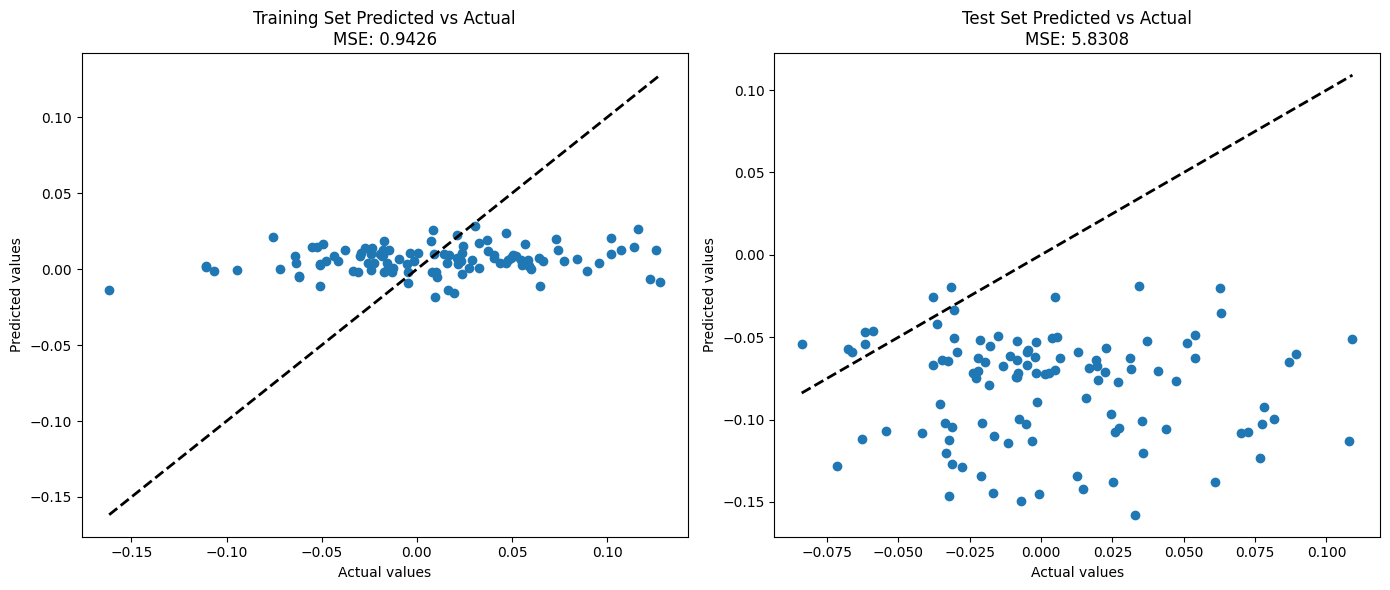

In [52]:
# Ensure the model is in evaluation mode
# Function to get predictions
def get_predictions(loader, model):
    model.eval()
    targets = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            targets.extend(labels.numpy())
            predictions.extend(outputs.numpy())

    return np.array(targets).flatten(), np.array(predictions).flatten()

# Get predictions for both training and test sets
train_sample = [get_predictions(train_loader, models[seed]) for seed in range(num_seeds)]
test_sample = [get_predictions(test_loader, models[seed]) for seed in range(num_seeds)]
train_targets = train_sample[0][0]

#
train_predictions = np.concatenate([train_sample[seed][1].reshape(-1, 1) for seed in range(num_seeds)], axis=1).mean(1)

test_targets = test_sample[0][0]
all_test_predictions = np.concatenate([test_sample[seed][1].reshape(-1, 1) for seed in range(num_seeds)], axis=1)
test_predictions = all_test_predictions.mean(1)

# Calculate MSE for both training and test sets
train_mse = np.mean((train_targets - train_predictions) ** 2) / np.mean(train_targets ** 2)
test_mse = np.mean((test_targets.reshape(-1, 1) - test_predictions) ** 2) / np.mean(test_targets ** 2)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Training set subplot
axs[0].scatter(train_targets, train_predictions)
axs[0].plot([train_targets.min(), train_targets.max()], [train_targets.min(), train_targets.max()], 'k--', lw=2)  # Diagonal line
axs[0].set_xlabel('Actual values')
axs[0].set_ylabel('Predicted values')
axs[0].set_title(f'Training Set Predicted vs Actual\nMSE: {train_mse:.4f}')

# Test set subplot
axs[1].scatter(test_targets, test_predictions)#.mean(1))
axs[1].plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'k--', lw=2)  # Diagonal line
axs[1].set_xlabel('Actual values')
axs[1].set_ylabel('Predicted values')
axs[1].set_title(f'Test Set Predicted vs Actual\nMSE: {test_mse:.4f}')

plt.tight_layout()
plt.show()


Text(0.5, 1.0, '0    0.26\n1   -0.32\ndtype: float32')

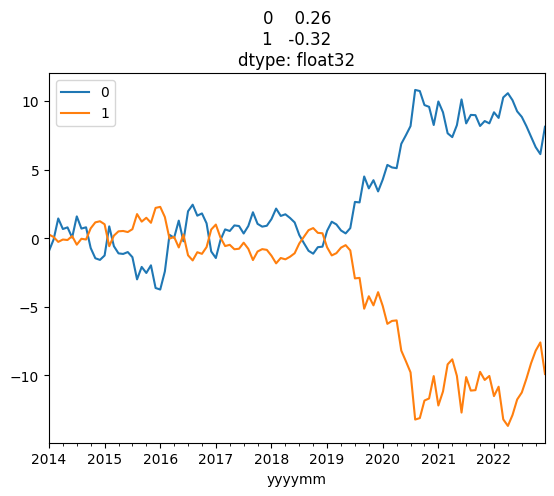

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# now I define R_{t+1} * pi_t
# test_predictions have 10 columns, each column corresponding to a different random seed
timed_returns = test_targets.reshape(-1, 1) * test_predictions.reshape(-1, 1)
together = pd.DataFrame(np.concatenate([test_targets.reshape(-1, 1), timed_returns], axis=1), index=test_dates)
(together / together.std()).cumsum().plot()
plt.title(f'{GoyalWelchData.sharpe_ratio(together)}')

# **FINE TUNING**

# Let us now try to understand what is going on.
# Remeber what the NN does: It samples the weights and biases $W_1$ (first hidden layer weights), $W_2$ (second hidden layer weights) and $W_3$ (output layer weights) as well as biases $b_1,b_2,b_3$ from $N(0, (scale/\sqrt{width})^2).$
$$
f(x) = W_3\sigma(W_2 \sigma(W_1x+b_1)+b_2)\ +\ b_3
$$
#Here,
$$
x\in \mathbb R^d,\ W_1\in \mathbb R^{n\times d}, b_1\in \mathbb R^n, W_2\in \mathbb R^{n\times n}, b_2\in \mathbb R^n, W_3\in \mathbb R^{1\times n}
$$
#Thus, we can define last-hidden-layer features
$$
h_i(x)\ =\ \sigma(W_{2,i} \sigma(W_1x+b_1)+b_{2,i}), i =1,...,n
$$
#(for us, $n=64$) and
$$
f(x)\ =\ \sum_{i=1}^n W_{3,i}h_i(x)\ +\ b_3
$$
#Well, then we can just use the **learned features** $h_i(x)$ to run the model as a simple linear model. Perhaps we could do even better?

In [54]:
model = models[0]
model.eval()
train_data_predictions, train_data_features = model(X_train_tensor, return_last_hidden=True)
print(train_data_predictions.shape)
print(train_data_features.shape)

test_data_predictions, test_data_features = model(X_test_tensor, return_last_hidden=True)


torch.Size([108, 1])
torch.Size([108, 100])


In [55]:
output_layer = list(model.layers)[-1]  # Get the last layer
# Now, access its weights and biases
weights = output_layer.weight.data
biases = output_layer.bias.data
print("Weights of the output layer:", weights)
print("Biases of the output layer:", biases)

Weights of the output layer: tensor([[-0.0187,  0.0605, -0.0229,  0.0392,  0.1413, -0.1636, -0.0222, -0.1055,
          0.1192, -0.0266, -0.0148,  0.0269,  0.0655, -0.1226, -0.0641, -0.1299,
         -0.1335, -0.0175,  0.0503,  0.0546, -0.0446, -0.0667,  0.0417, -0.0223,
         -0.0502, -0.1123,  0.0594,  0.0955,  0.0277,  0.1444, -0.0705, -0.0369,
         -0.0712, -0.0131,  0.0397,  0.1171,  0.0767, -0.0796,  0.1348,  0.0082,
         -0.0360, -0.0074,  0.0129, -0.1272,  0.0231,  0.0885,  0.0012, -0.1890,
         -0.1153, -0.0027,  0.0031,  0.1740,  0.0458,  0.0587,  0.0324,  0.0747,
         -0.0565, -0.0365,  0.0837, -0.0109,  0.1501, -0.2017, -0.0311,  0.0305,
          0.0313,  0.0573, -0.1966, -0.0190, -0.0830, -0.0475, -0.0050,  0.0097,
          0.0398,  0.0549,  0.1059, -0.0624, -0.0651, -0.0489,  0.0893, -0.0697,
         -0.1412,  0.0022,  0.2127,  0.1060, -0.0220, -0.0487, -0.0156,  0.0290,
          0.0973, -0.1559, -0.0129, -0.1319, -0.0937, -0.0440,  0.1162, -0.0806,

#Note that
$$
f(x)\ =\ \sum_{i=1}^n W_{3,i}h_i(x) +b_3\cdot 1
$$
#and hence, to re-produce the output of the neural net, we need to add an "additional" feature equal to 1. We do this using torch.ones([train_data_features.shape[0], 1])

In [56]:
new_X_train = torch.concatenate([train_data_features, torch.ones([train_data_features.shape[0], 1])], axis=1)
new_X_test = torch.concatenate([test_data_features, torch.ones([test_data_features.shape[0], 1])], axis=1)


In [57]:
def ridge_regr(signals: np.ndarray,
                  labels: np.ndarray,
                  future_signals: np.ndarray,
                  shrinkage_list: np.ndarray):
    """
    Regression is
    beta = (zI + S'S/t)^{-1}S'y/t = S' (zI+SS'/t)^{-1}y/t
    Inverting matrices is costly, so we use eigenvalue decomposition:
    (zI+A)^{-1} = U (zI+D)^{-1} U' where UDU' = A is eigenvalue decomposition,
    and we use the fact that D @ B = (diag(D) * B) for diagonal D, which saves a lot of compute cost
    :param signals: S
    :param labels: y
    :param future_signals: out of sample y
    :param shrinkage_list: list of ridge parameters
    :return:
    """
    t_ = signals.shape[0]
    p_ = signals.shape[1]
    if p_ < t_:
        # this is standard regression
        eigenvalues, eigenvectors = np.linalg.eigh(signals.T @ signals / t_)
        means = signals.T @ labels.reshape(-1, 1) / t_
        multiplied = eigenvectors.T @ means
        intermed = np.concatenate([(1 / (eigenvalues.reshape(-1, 1) + z)) * multiplied for z in shrinkage_list],
                                  axis=1)
        betas = eigenvectors @ intermed
    else:
        # this is the weird over-parametrized regime
        eigenvalues, eigenvectors = np.linalg.eigh(signals @ signals.T / t_)
        means = labels.reshape(-1, 1) / t_
        multiplied = eigenvectors.T @ means
        intermed = np.concatenate([(1 / (eigenvalues.reshape(-1, 1) + z)) * multiplied for z in shrinkage_list],
                                  axis=1)
        tmp = eigenvectors.T @ signals
        betas = tmp.T @ intermed
    predictions = future_signals @ betas
    return betas, predictions

In [58]:
shrinkage_list = [0.00000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
beta_estimate_using_train_sample, oos_predictions = ridge_regr(signals=new_X_train.detach().numpy(),
                                                                labels=y_train,
                                                                future_signals=new_X_test.detach().numpy(),
                                                                shrinkage_list=shrinkage_list)


In [59]:
fine_tuned_mse = np.mean((test_targets.reshape(-1, 1) - oos_predictions) ** 2, axis=0) / np.mean((test_targets) ** 2)
print(fine_tuned_mse)

[776.40157313  97.50632421  22.54457348   6.38832709   2.39067081
   1.04377715   0.99458477   0.99640525   0.99943211   0.99994033]


Text(0.5, 1.0, '0     0.26\n1    -0.00\n2    -0.15\n3    -0.16\n4    -0.17\n5    -0.12\n6     0.03\n7     0.28\n8     0.24\n9     0.23\n10    0.23\ndtype: float64')

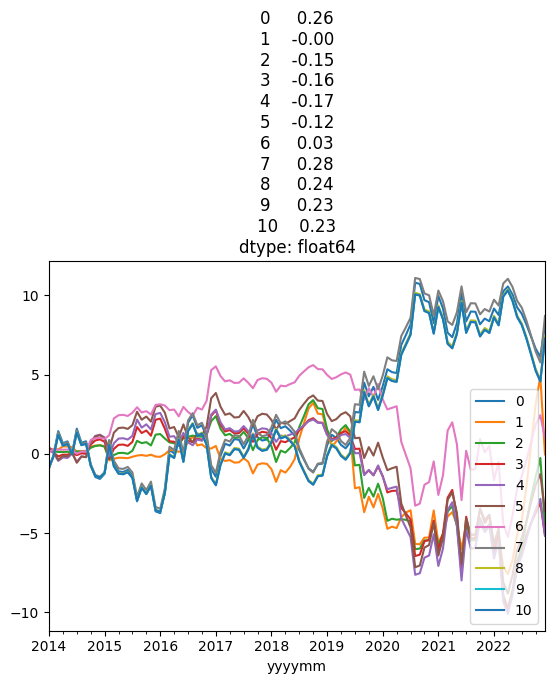

In [60]:
timed_returns = test_targets.reshape(-1, 1) * oos_predictions
together = pd.DataFrame(np.concatenate([test_targets.reshape(-1, 1), timed_returns], axis=1), index=test_dates)
(together / together.std()).cumsum().plot()
plt.title(f'{GoyalWelchData.sharpe_ratio(together)}')